In [1]:
import os
from pathlib import Path
os.chdir(os.path.abspath("./.."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import datetime

from utils.data_io import *
from utils.common import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Masking, Dropout, Dense, Conv1D, GRU, LSTM, BatchNormalization
import tensorboard
import tensorflow_addons as tfa

tf.config.run_functions_eagerly(True)
# tf.config.threading.set_inter_op_parallelism_threads(0)

from src.dx5849_training_data_3src import *


def data_zero_masking(data):
    data[np.isnan(data)] = 0
    return data

root_folder = os.path.abspath('.')
data_folder = os.path.join(root_folder, 'processed/patient_data/dx_pred_0_12_3src')

X_train, X_test, y_train, y_test = np.load(os.path.join(data_folder, 'data_split_8020.npy'), allow_pickle=True)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

info_test, data_test, label_test = np.load(os.path.join(data_folder, 'test_data.npy'), allow_pickle=True)
info_test = data_zero_masking(info_test)
data_test = data_zero_masking(data_test)[:,:,1:]

tf.test.gpu_device_name()

/home/dhm/workspace/conference_projects/MICCAI2022_AKF_feature_importance


2022-01-04 12:56:20.173234: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 12:56:20.236566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 12:56:20.263685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 12:56:20.263849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

'/device:GPU:0'

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 12:56:20.845522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 12:56:20.846083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 6098 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5


In [2]:
static_input_shape = (4)
time_series_shape = (144, 25)
N_filter_per_feature = 3

static_inputs = Input(shape=static_input_shape, dtype='float64', name='static_inputs')
time_series_inputs = Input(shape=time_series_shape, dtype='float64', name='time_series_inputs')

x = time_series_inputs
x = Masking(mask_value=.0)(x)
x = BatchNormalization(axis=2, name='norm_input')(x)
print('Masked Input: ', x.shape)
x = Conv1D(filters=N_filter_per_feature*25, kernel_size=144, groups=25,
           activation='relu', 
           name='conv1d')(x)
print('Conv1D: ', x.shape)

x = tf.reshape(x, [-1, x.shape[1]*x.shape[2]])
x = layers.concatenate([static_inputs, x])
print('Concanated input for Dense layers: ', x.shape)

x = Dense(32, activation='relu', name='dense1')(x)
print('Dense1: ', x.shape)
x = Dropout(0.5)(x)
x = BatchNormalization(name='norm_dense1')(x)

x = Dense(16, activation='relu', name='dense2')(x)
print('Dense2: ', x.shape)
x = Dropout(0.5)(x)
x = BatchNormalization(name='norm_dense2')(x)

output = Dense(1, activation='sigmoid', name='output')(x)
print('Output: ', output.shape)

model = keras.Model(inputs=[static_inputs, time_series_inputs], 
                    outputs=[output])

model.summary()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

log_names = ['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc']


# LOSS = keras.losses.BinaryCrossentropy(name='loss')
LOSS = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.75, gamma=2, name='loss')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=LOSS,
    metrics=METRICS,
)

Masked Input:  (None, 144, 25)
Conv1D:  (None, 1, 75)
Concanated input for Dense layers:  (None, 79)
Dense1:  (None, 32)
Dense2:  (None, 16)
Output:  (None, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_series_inputs (InputLayer  [(None, 144, 25)]   0           []                               
 )                                                                                                
                                                                                                  
 masking (Masking)              (None, 144, 25)      0           ['time_series_inputs[0][0]']     
                                                                                                  
 norm_input (BatchNormalization  (None, 144, 25)     100         ['masking[0][0]']                
 )                               

2021-12-14 00:58:53.868112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 00:58:53.868348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 00:58:53.868479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 00:58:53.868751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 00:58:53.868876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [3]:
sum(y_train) / len(y_train), sum(y_test) / len(y_test) 

(0.22135170189644898, 0.22133417464156763)

In [4]:
len(y_train), sum(y_train), len(y_test), sum(y_test)

(114108, 25258, 28527, 6314)

In [3]:
epoch = 5
cv_splits = 20
batch_size = 256

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


train_log_dir = 'models/Conv1D/logs/' + current_time + '/train'
test_log_dir = 'models/Conv1D/logs/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

class_weight = {
    0: sum(y_train) / len(y_train),
    1: 1 - sum(y_train) / len(y_train),
}


batches_processed_counter = 0

for epoch_i in range(epoch):
    batch_generator = generate_data_batch_raw(X_train, y_train,
                                              batchsize=batch_size,
                                              resample_freq=None)


    for batch_i, (info, data, label) in enumerate(batch_generator):
        batches_processed_counter = batches_processed_counter  + 1
        info = data_zero_masking(info)
        data = data_zero_masking(data)[:,:,1:]

        log_train = model.train_on_batch({'static_inputs': info, 'time_series_inputs': data},
                                         label,
                                         reset_metrics=False, return_dict=True)
        
        with train_summary_writer.as_default():
            for log in log_train:
                tf.summary.scalar(log, log_train[log], step=batches_processed_counter)
        

        if batch_i % 20 == 0:
            log_test = model.evaluate({'static_inputs': info_test, 'time_series_inputs': data_test}, 
                                      {'output': label_test}, return_dict=True)
            
            with test_summary_writer.as_default():
                for log in log_test:
                    tf.summary.scalar(log, log_test[log], step=batches_processed_counter)

            print(f'Epoch: {epoch_i}, Batch: {batch_i}')
            print('\tTrainLoss: ', log_train['loss'], 'TrainAcc: ', log_train['accuracy'], 'TrainAUC: ', log_train['auc'])
            print('\tTestLoss: ', log_test['loss'], 'TestAcc: ', log_test['accuracy'], 'TestAUC: ', log_test['auc'], '\n')
            
model.save('models/Conv1D/logs/' + current_time + '/model')

2021-12-14 10:37:27.870256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 10:37:27.870664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 10:37:27.870982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 10:37:27.871647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 10:37:27.871957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

NameError: name 'model' is not defined

In [2]:
logs = os.listdir('./models/Conv1D/logs/')
log_ts = [datetime.datetime.strptime(log_ts[:15], "%Y%m%d-%H%M%S") for log_ts in logs]
log_latest = logs[log_ts.index(max(log_ts))]

%load_ext tensorboard
%tensorboard --logdir ./models/Conv1D/logs/{log_latest}

In [4]:
model = keras.models.load_model(f"models/Conv1D/models/{log_latest}")

2021-12-15 11:42:22.443708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:42:22.443978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:42:22.444151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:42:22.444561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:42:22.444756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

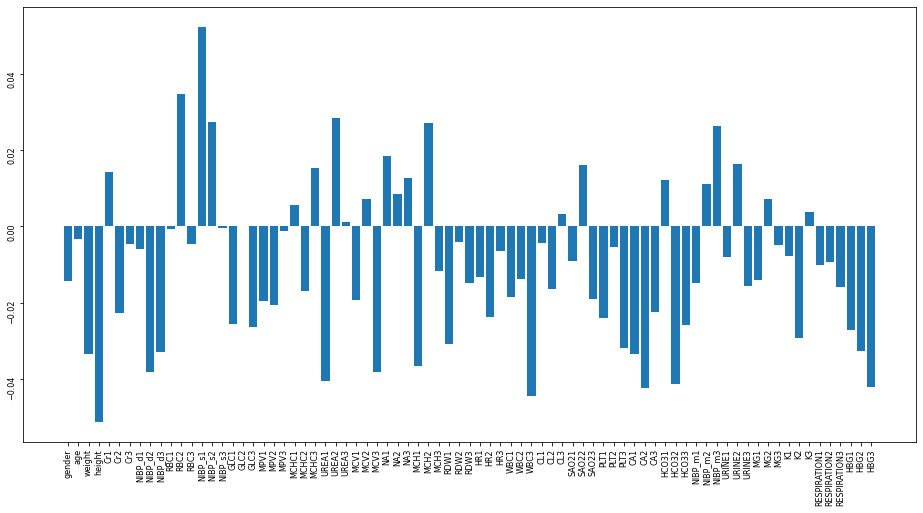

In [5]:
# Weights of first dense layer

filters, biases = model.get_layer('dense1').get_weights()
filters.shape

fig, ax = plt.subplots(figsize=(16, 8))

feature_names = [
    'Cr', 'NIBP_d','RBC', 'NIBP_s', 'GLC', 'MPV', 'MCHC', 
    'UREA', 'MCV', 'NA', 'MCH', 'RDW', 'HR', 'WBC', 'CL',
    'SAO2', 'PLT', 'CA', 'HCO3', 'NIBP_m', 'URINE', 'MG', 'K', 'RESPIRATION', 'HBG'
]

xticks = []
for feat in feature_names:
    for i in ['1', '2', '3']:
        xticks += [feat+i]
xticks = ['gender', 'age', 'weight', 'height'] + xticks
ax.bar(xticks, np.mean(filters, axis=1))
ax.tick_params(labelrotation=90, labelsize=8)

<BarContainer object of 75 artists>

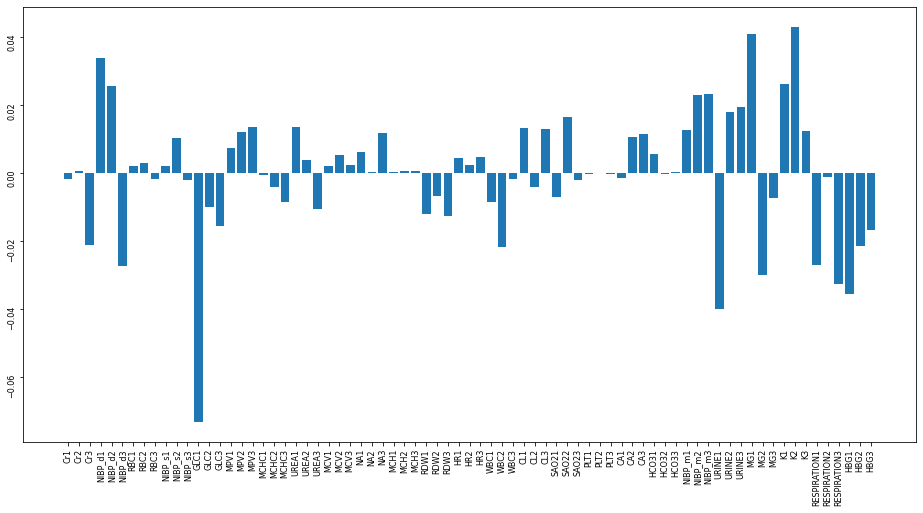

In [6]:
feature_names = [
    'Cr', 'NIBP_d','RBC', 'NIBP_s', 'GLC', 'MPV', 'MCHC', 
    'UREA', 'MCV', 'NA', 'MCH', 'RDW', 'HR', 'WBC', 'CL',
    'SAO2', 'PLT', 'CA', 'HCO3', 'NIBP_m', 'URINE', 'MG', 'K', 'RESPIRATION', 'HBG'
]

filters, biases = model.get_layer('conv1d').get_weights()
f = np.mean(filters, axis=0).reshape(-1)

fig, ax = plt.subplots(figsize=(16, 8))

xticks = []
for feat in feature_names:
    for i in ['1', '2', '3']:
        xticks += [feat+i]
xticks = xticks
ax.tick_params(labelrotation=90, labelsize=8)
ax.bar(xticks, f)


In [ ]:
# Weights of convolutional layer

feature_names = [
    'Cr', 'NIBP_d','RBC', 'NIBP_s', 'GLC', 'MPV', 'MCHC', 
    'UREA', 'MCV', 'NA', 'MCH', 'RDW', 'HR', 'WBC', 'CL',
    'SAO2', 'PLT', 'CA', 'HCO3', 'NIBP_m', 'URINE', 'MG', 'K', 'RESPIRATION', 'HBG'
]


filters, biases = model.get_layer('conv1d').get_weights()
f = np.mean(np.mean(filters, axis=0), axis=1)

fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(feature_names, f.flatten())
ax.tick_params(labelrotation=90, labelsize=8)

# CNN kernel size adjust

In [1]:
import os
os.chdir(os.path.abspath("./.."))

import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Masking, Dropout, Dense, Conv1D, GRU, LSTM, BatchNormalization
import tensorflow_addons as tfa

tf.config.run_functions_eagerly(True)

import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

from src.dx5849_training_data_3src import *


class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()


def data_zero_masking(data):
    data[np.isnan(data)] = 0
    return data

def build_model(kernel_size=10, n_filter=3, dense_layer=[128]):
    # Model Setup
    static_input_shape = (4)
    time_series_shape = (144, 25)

    static_inputs = Input(shape=static_input_shape, dtype='float64', name='static_inputs')
    time_series_inputs = Input(shape=time_series_shape, dtype='float64', name='time_series_inputs')

    x = time_series_inputs
    x = Masking(mask_value=.0)(x)
    x = BatchNormalization(axis=2, name='norm_input')(x)
    # print('Masked Input: ', x.shape)
    x = Conv1D(filters=n_filter*25, kernel_size=kernel_size, groups=25,
               activation='relu',
               name='conv1d')(x)
    # print('Conv1D: ', x.shape)

    x = tf.reshape(x, [-1, x.shape[1]*x.shape[2]])
    x = layers.concatenate([static_inputs, x])
    # print('Concanated input for Dense layers: ', x.shape)
    
    for dense_i, dense_size in enumerate(dense_layer):
        x = Dense(dense_size, activation='relu', name=f'dense_{dense_i}')(x)
        # print('Dense1: ', x.shape)
        x = Dropout(0.5)(x)
        x = BatchNormalization(name=f'norm_dense_{dense_i}')(x)

    output = Dense(1, activation='sigmoid', name='output')(x)
    # print('Output: ', output.shape)

    model = keras.Model(inputs=[static_inputs, time_series_inputs],
                        outputs=[output])
    return model

/home/dhm/workspace/conference_projects/MICCAI2022_AKF_feature_importance


In [2]:
root_folder = os.path.abspath('.')
data_folder = os.path.join(root_folder, 'processed/patient_data/dx_pred_6_12_3src')

_, X_test, _, y_test = np.load(os.path.join(data_folder, 'data_split_8020.npy'), allow_pickle=True)
X_test = np.array(X_test)
y_test = np.array(y_test)

info_test, data_test, label_test = np.load(os.path.join(data_folder, 'test_data.npy'), allow_pickle=True)
info_test = data_zero_masking(info_test)
data_test = data_zero_masking(data_test)[:,:,1:]

N_val = int(len(label_test)/2)
dataset_val = ({'static_inputs': info_test[:N_val], 'time_series_inputs': data_test[:N_val]}, label_test[:N_val])
dataset_test = ({'static_inputs': info_test[N_val:], 'time_series_inputs': data_test[N_val:]}, label_test[N_val:])

EPOCH = 100
BATCH_SIZE = 256
# ds_test = tf.data.experimental.load('processed/patient_data/dx_pred_0_12_3src/tf_dataset/dataset_test')
ds_pos = tf.data.experimental.load(os.path.join(data_folder, 'tf_dataset/dataset_train_pos'))
ds_neg = tf.data.experimental.load(os.path.join(data_folder, 'tf_dataset/dataset_train_neg'))
ds_train = generate_equally_resampled_tf_dataset(ds_pos, ds_neg)
ds_train = ds_train.batch(BATCH_SIZE).prefetch(2)
STEP_PER_EPOCH = np.ceil(2 * ds_neg.cardinality().numpy() / BATCH_SIZE)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

LOSS = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.75, gamma=2, name='loss')

/home/dhm/workspace/conference_projects/tf-py38/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-01-05 00:17:10.139571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 00:17:10.143345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 00:17:10.143502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least 

In [ ]:
KERNEL_SIZES = [10, 20, 30, 40, 50]
FILTER_NUMS = [1, 2, 3, 4, 5]
DENSE_LAYERS = [[128], [256], [128, 64]]

for n_filter in FILTER_NUMS:
    for kernel_size in KERNEL_SIZES:
        for dense_layer in DENSE_LAYERS:
            
            model = build_model(n_filter=n_filter, kernel_size=kernel_size, dense_layer=dense_layer)
            model.summary()
            
            current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            CALLBACKS = [
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=1e-5,
                    patience=5,
                    verbose=1,
                ),

                keras.callbacks.ModelCheckpoint(
                    filepath=f'./models/Conv1D/models/{current_time}_F{n_filter}_K{kernel_size}_D{dense_layer}',
                    save_weights_only=False,
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True,
                    save_freq='epoch',
                ),

                keras.callbacks.TensorBoard(log_dir=f"./models/Conv1D/logs/{current_time}_F{n_filter}_K{kernel_size}_D{dense_layer}"),

                ClearMemory(),
            ]
            
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                loss=LOSS,
                metrics=METRICS,
                run_eagerly=True,
            )
            
            history = model.fit(
                ds_train,
                epochs=EPOCH,
                steps_per_epoch=STEP_PER_EPOCH,
                # validation_steps=int(0.1 * STEP_PER_EPOCH),
                # validation_freq=1,
                validation_data=(dataset_val[0], dataset_val[1]),
                callbacks=CALLBACKS,
            )
            np.save(os.path.join(os.path.abspath("/home/dhm/workspace/conference_projects/MICCAI2022_AKF_feature_importance/models/Conv1D/logs"), current_time, 'train_history'), 
                    allow_pickle=True)

In [3]:
f'{[128, 64]}'

'[128, 64]'